In [1]:
import random

from data_generator.csv_data_processor import CSVDataProcessor
from utils.statistical_functions import create_distributed_age_df
from utils.udf_functions import create_random_dob_udf, create_fake_name_udf, random_gender_pd_udf, choose_blood_type_udf
from utils.read_write import read_postgres_table
from spark_instance import spark
from utils.data_vis.data_visualisations import plot_age_distribution_with_sd, plot_kernel_density_age_distribution


from pyspark.sql.functions import col, lower, array, concat_ws, date_format, sum
  

24/04/20 17:47:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/Users/jacobbickerstaff/Desktop/Development/health-data-etl-kaggle/venv/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
average_age = 40.2

csv_age_file_file = CSVDataProcessor(spark, "data/uk_age_population.csv")

csv_age_uk_df = csv_age_file_file.runner()

In [6]:
csv_age_uk_df.show()

+----------+--------------------+--------------+----------+-----+--------+------+---+--------------------+----------------+
|sourceyear|              author|      location|       sex|ageid|agestart|ageend|age|        estimatetype|population_total|
+----------+--------------------+--------------+----------+-----+--------+------+---+--------------------+----------------+
|      2022|United Nations Po...|United Kingdom|Both sexes|   42|       0|     1|  0|Model-based Estim...|          678115|
|      2022|United Nations Po...|United Kingdom|Both sexes|   89|       1|     1|  1|Model-based Estim...|          679828|
|      2022|United Nations Po...|United Kingdom|Both sexes|  117|       2|     2|  2|Model-based Estim...|          682987|
|      2022|United Nations Po...|United Kingdom|Both sexes|  126|       3|     3|  3|Model-based Estim...|          702265|
|      2022|United Nations Po...|United Kingdom|Both sexes|  135|       4|     4|  4|Model-based Estim...|          733315|
|      2

In [7]:
import math

# Calculate the squared differences from the known mean, weighted by the population total
csv_age_uk_sq_df = csv_age_uk_df.withColumn("weighted_squared_diff", (col("age") - average_age) ** 2 * col("population_total"))

# Sum up the weighted squared differences and the total population
total_weighted_squared_diff = csv_age_uk_sq_df.select(sum("weighted_squared_diff")).collect()[0][0]
total_population = csv_age_uk_sq_df.select(sum("population_total")).collect()[0][0]

# Calculate the weighted variance
weighted_variance = total_weighted_squared_diff / total_population

# Calculate the weighted standard deviation
weighted_standard_deviation = math.sqrt(weighted_variance)

print("Weighted Standard Deviation of Age:", weighted_standard_deviation)


Weighted Standard Deviation of Age: 23.868386921247534


In [5]:
plot_age_distribution_with_sd(csv_age_uk_df, average_age)


NameError: name 'csv_age_uk_df' is not defined

In [7]:
plot_kernel_density_age_distribution(csv_age_uk_df)


NameError: name 'csv_age_uk_df' is not defined

In [2]:
sampled_df = create_distributed_age_df(spark,  "data/uk_age_population.csv")

In [3]:
sampled_df_aggregated = sampled_df.groupby(col("Age")).count()

In [10]:
sampled_df_aggregated.orderBy("Age").show(n=200)

+---+-----+
|Age|count|
+---+-----+
|  0|  101|
|  1|  101|
|  2|  100|
|  3|  103|
|  4|  109|
|  5|  112|
|  6|  115|
|  7|  119|
|  8|  115|
|  9|  120|
| 10|  123|
| 11|  124|
| 12|  123|
| 13|  127|
| 14|  122|
| 15|  120|
| 16|  118|
| 17|  116|
| 18|  115|
| 19|  113|
| 20|  112|
| 21|  108|
| 22|  106|
| 23|  118|
| 24|  129|
| 25|  121|
| 26|  122|
| 27|  127|
| 28|  132|
| 29|  137|
| 30|  137|
| 31|  135|
| 32|  133|
| 33|  139|
| 34|  131|
| 35|  135|
| 36|  135|
| 37|  134|
| 38|  132|
| 39|  125|
| 40|  129|
| 41|  127|
| 42|  131|
| 43|  130|
| 44|  126|
| 45|  117|
| 46|  114|
| 47|  118|
| 48|  114|
| 49|  122|
| 50|  127|
| 51|  134|
| 52|  139|
| 53|  131|
| 54|  138|
| 55|  138|
| 56|  134|
| 57|  138|
| 58|  143|
| 59|  136|
| 60|  131|
| 61|  130|
| 62|  124|
| 63|  121|
| 64|  113|
| 65|  114|
| 66|  109|
| 67|  108|
| 68|  101|
| 69|   94|
| 70|   94|
| 71|   95|
| 72|   89|
| 73|   93|
| 74|   97|
| 75|  100|
| 76|   93|
| 77|   86|
| 78|   79|
| 79|   75|
| 80

In [21]:
# Calculate the squared differences from the known mean, weighted by the population total
small_sample_df = sampled_df_aggregated.withColumn("weighted_squared_diff", (col("age") - 40.2) ** 2 * col("count"))

# Sum up the weighted squared differences and the total population
total_weighted_squared_diff = small_sample_df.select(sum("weighted_squared_diff")).collect()[0][0]
total_population = small_sample_df.select(sum("count")).collect()[0][0]

# Calculate the weighted variance
weighted_variance = total_weighted_squared_diff / total_population

# Calculate the weighted standard deviation
weighted_standard_deviation = math.sqrt(weighted_variance)

print("Weighted Standard Deviation of Age:", weighted_standard_deviation)

Weighted Standard Deviation of Age: 23.89101504750269


+---+----------------+
|age|population_total|
+---+----------------+
| 95|               8|
| 62|             128|
| 66|             110|
| 93|              11|
| 60|             120|
| 56|             140|
| 74|              94|
| 36|             138|
| 58|             141|
|  7|             122|
| 70|              96|
| 69|              98|
| 17|             118|
| 18|             110|
| 38|             134|
| 81|              60|
| 42|             128|
| 46|             116|
| 61|             131|
|  3|             104|
+---+----------------+


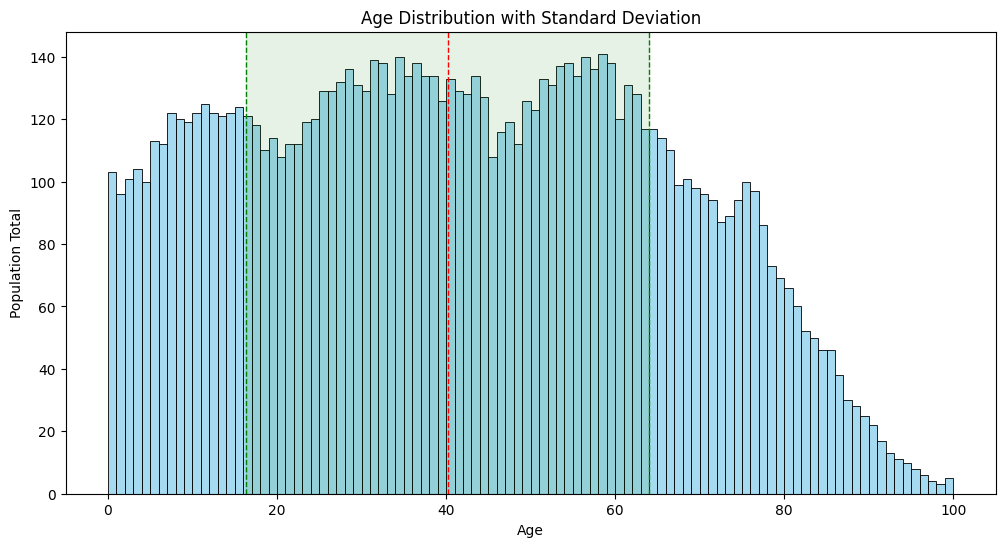

In [15]:
plot_age_distribution_with_sd(sampled_df_aggregated)

In [62]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql import DataFrame


def create_unique_id(non_unique_id_df: DataFrame) -> DataFrame:
    """
    Cleans a name column by removing spaces and periods, and then concatenates it with a date column to form a unique ID.

    Args:
        non_unique_id_df (DataFrame): The input DataFrame that contains the name and date of birth columns.
    Returns:
        DataFrame: A DataFrame with an added column that combines cleaned names with dates of birth into a unique ID.
    """
    # Clean the 'name' column by removing periods and replacing spaces with underscores
    cleaned_df = non_unique_id_df.withColumn(
        "clean_name",
        regexp_replace(regexp_replace(col("name"), "\\.", ""), "\\s", "_")
    )

    return cleaned_df.withColumn(
        "unique_id",
        concat_ws("_", col("clean_name"), col("DOB"))
    ).drop("clean_name")


In [63]:
from pyspark.sql.functions import lit

is_female = lower(col('gender')) == 'female'
is_pediatric = col("Age") < 18
is_geriatric = (col("Age") >= 65)

sampled_df = sampled_df.withColumn("size", lit(1))
sampled_df_with_name = (sampled_df.withColumn("name", create_fake_name_udf(col("size")))
                                           .withColumn("DOB", create_random_dob_udf(col("Age")))
                                           .withColumn("gender", random_gender_pd_udf(lit("uk")))
                                           .withColumn("blood_type", choose_blood_type_udf(col("size")))
                                           .withColumn("is_female", is_female)
                                           .withColumn("is_pediatric", is_pediatric)
                                           .withColumn("is_geriatric", is_geriatric)
                        .drop("size"))
sampled_df_with_unique_id = create_unique_id(sampled_df_with_name)

In [64]:
sampled_df_with_unique_id.show()

+---+-----------------+--------+------+----------+---------+------------+------------+--------------------+
|Age|             name|     DOB|gender|blood_type|is_female|is_pediatric|is_geriatric|           unique_id|
+---+-----------------+--------+------+----------+---------+------------+------------+--------------------+
| 71|         G. Patel|19521218|Female|        A-|     true|       false|        true|    G_Patel_19521218|
| 52|    J. Fitzgerald|19720129|Female|        A+|     true|       false|       false|J_Fitzgerald_1972...|
| 19|          D. Soto|20040723|Female|        A+|     true|       false|       false|     D_Soto_20040723|
| 47|       G. H. Reed|19770315|  Male|        O-|    false|       false|       false|   G_H_Reed_19770315|
| 57|       Z. Stewart|19670313|Female|        A-|     true|       false|       false|  Z_Stewart_19670313|
| 69|          P. Wong|19540603|Female|        A+|     true|       false|        true|     P_Wong_19540603|
| 32|         V. Smith|19910

0     71
1     52
2     19
3     47
4     57
5     69
6     32
7     28
8     28
9     42
10    60
11    18
12    26
13    35
14    32
15    13
16    67
17     6
18    84
19    38
20    15
Name: _1, dtype: int64


In [ ]:
# will be scrapping this shortly 
# csv_reader = CSVDataProcessor(spark, "data/healthcare_dataset.csv")

# # Read the CSV file
# raw_df = csv_reader.run()


In [ ]:
# above is commented out as it's saved in the database:
df = read_postgres_table("dob_age_raw_data")

In [ ]:
from constants.admission_types_dataset import admission_mapping, AdmissionTypes
flattened = [
    (
        top_level.name,
        sub_level_key.name,
        list(sub_level_info.get("stay_types")),
        sub_level_info.get("tests"),  
        random.choice(sub_level_info.get("doctors"))
    )
    for top_level, sub_level_dict in admission_mapping.items()
    for sub_level_key, sub_level_info in sub_level_dict.items()
]



In [ ]:
flattened

In [ ]:
from constants.condition_probabilities import condition_age_probability_dict

flattened_condition_probabilities = [
    (
        sub_admission,
        condition,
        gender if gender in ['male', 'female'] else None,
        float(age_range[0]),
        float(age_range[1]) if len(age_range) > 1 else float('inf'),
        float(probability) 
    )
    for sub_admission, conditions in condition_age_probability_dict.items()
    for condition, genders_or_age_prob_list in conditions.items()
    for gender, age_prob_list in (genders_or_age_prob_list.items() if isinstance(genders_or_age_prob_list, dict) else [(None, genders_or_age_prob_list)])
    for age_range, probability in age_prob_list
]



In [ ]:
flattened_condition_probabilities

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType

columns = ["condition_admission_type", "condition", "gender", "age_min", "age_max", "probability"]
schema = StructType([
    StructField("condition_admission_type", StringType(), True),
    StructField("condition", StringType(), True),
    StructField("condition_gender", StringType(), True),  # Assuming gender can be specific probability for gender 'male', 'female', or null
    StructField("age_min", FloatType(), False),
    StructField("age_max", FloatType(), False),
    StructField("probability", FloatType(), False)
])



condition_prob_df = spark.createDataFrame(data=flattened_condition_probabilities, schema=schema)


In [ ]:
condition_prob_df.show()

In [ ]:
"""
STEP 1 
    From the flattened data list we wish to create a DataFrame. This contains all the possible combinations for the given 
    top level admissions, sub level admissions, stay types and list of tests available from the admission_mapping, stay_type and admission_tests lists or dictionaries in admission_types_test_dataset.py
"""

mapping_df = spark.createDataFrame(flattened, ["top_level_admission", "sub_level_admission", "stay_types", "possible_tests", "doctor"])

joined_tbl = mapping_df.join(condition_prob_df, on=[mapping_df.sub_level_admission == condition_prob_df.condition_admission_type], how="left")

In [ ]:
"""
STEP 2 
    Create a list of admission_types randomly assign this to the original patient in the original data set, 
    whilst dropping the original admission_type column. Then join with mapping_df on top_level_admission col to give access to possible 
    conditions, mappings and so on.
"""
admission_type_names = [member.name for member in AdmissionTypes]

keys_array = array([lit(name) for name in admission_type_names])

# Define constants and conditions
female_only = ["MATERNITY", 'obstetrics']
is_female = lower(col('gender')) == 'female'
is_pediatric = col("Age") < 18
is_geriatric = (col("Age") >= 65)

df = (df.withColumn("is_female", is_female)
        .withColumn("is_pediatric", is_pediatric)
        .withColumn("is_geriatric", is_geriatric)
        .withColumn("unique_id", concat_ws("_", "name", date_format("DOB", "yyyyMMdd")))
        .drop("doctor", "medical_condition", "test_results", "medication", "admission_type")
      )



In [ ]:
df.show()

In [ ]:
"""
STEP 3  
Create Enum class df and join it on to main driver df. 
Then create conditions 
"""

from data_generator.conditions_creator import ConditionsCreator
from utils.thread_operations import runner
from constants.type_constants import DepartmentTypes

enum_values = [e.name for e in DepartmentTypes]

enum_df = spark.createDataFrame(enum_values, StringType()).toDF("admission_type")

selected_conditions_df = runner(spark, ConditionsCreator, df, joined_tbl, enum_df)


In [ ]:
# TODO:  
# tests to be chosen
# admission date to be chosen 
# hospital name 
# patient postcode 
# ethnicity distribution  
# _________________
# Long term 
# investigation which disease affects specific ethnicities
# blood type udf would need to consider ethnicity also eventually



In [ ]:
spark.stop()